<h>William Kiger - Kristopher Gallagher<br>
<h>DLH 598<br>
<h>Build Pre-Trained Resnet-18 with Softmax

In [1]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
from sklearn.metrics import confusion_matrix

from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

import os
import time
import numpy as np
import pandas as pd
import seaborn as sn 

In [2]:
# Defining Transformations 
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224), # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [3]:
# Load the Data
# Set train and valid directory paths

root = 'data'

train_directory = os.path.join(root, 'train')
valid_directory = os.path.join(root, 'valid')

# Number of classes
num_classes = len(os.listdir(valid_directory))  
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=10, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=10, shuffle=False)

10
{0: 'allergic_contact_dermatitis', 1: 'basal_cell_carcinoma', 2: 'folliculitis', 3: 'lichen_planus', 4: 'lupus_erythematosus', 5: 'neutrophilic_dermatoses', 6: 'photodermatoses', 7: 'psoriasis', 8: 'sarcoidosis', 9: 'squamous_cell_carcinoma'}


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

print("Training data at hand: " + str(train_data_size))
print("Validation data at hand: " + str(valid_data_size))

Training data at hand: 3543
Validation data at hand: 890


In [6]:
#pretrained is trained on ImageNet...just like our paper to replicate
resnet18 = models.resnet18(pretrained=True)
resnet18 = resnet18.to(device)

In [7]:
# Freeze parameters
for param in resnet18.parameters():
    param.requires_grad = False

In [8]:
fc_inputs = resnet18.fc.in_features

resnet18.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), #need to tune this for our number of classes.  10 in this case
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)
resnet18 = resnet18.to(device)

In [9]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet18.parameters())

In [10]:
#get training...
train_start_time = time.time() 

#we are saving the model at the best validation loss, so run a lot of epochs...
epochs = 50

#for training metrics downstream
best_loss = 999999.0 #high so saves at base case
train_losses = []
test_losses = []
train_acc_list = []
test_acc_list = []

for epoch in range(epochs):
    epoch_start = time.time()
    
    # Loss and Accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0    
    valid_loss = 0.0
    valid_acc = 0.0
    
    #put model in training mode 
    resnet18.train()
    
    # training batches
    for i, (inputs, labels) in enumerate(train_data_loader):
#         i+=1
        
        inputs = inputs.to(device) #gpu...we hope...
        labels = labels.to(device) 
        
        optimizer.zero_grad() #zero out gradients
        outputs = resnet18(inputs) #forward pass
        loss = loss_func(outputs, labels) #compute loss
        loss.backward() #backpropagate gradients
        optimizer.step()
        
        # Compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() * inputs.size(0)
        
        # Tally the number of correct predictions
        predicted = torch.max(outputs.data, 1)[1]
        correct_counts = predicted.eq(labels.data.view_as(predicted))
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        train_acc += acc.item() * inputs.size(0)

        
    # Run the testing batches
    with torch.no_grad():
#         print("here")
        resnet18.eval() #eval mode
        
#         for b, (inputs, labels) in tqdm(enumerate(valid_data_loader)):
        for j, (inputs, labels) in enumerate(valid_data_loader):
#             j+=1
            inputs = inputs.to(device)
            labels = labels.to(device) 
            
            # Apply the model
            y_val = resnet18(inputs)
            v_loss = loss_func(y_val, labels) #compute loss
            valid_loss += v_loss.item() * inputs.size(0) #total loss for the batch and add it to valid_loss
        
            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
#             tst_corr += (predicted == labels).sum()
            
            #valid accuracy
            correct_counts = predicted.eq(labels.data.view_as(predicted))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            valid_acc += acc.item() * inputs.size(0)
            
    #store model if validation loss is less than best historical loss        
    if valid_loss < best_loss:
        best_loss = valid_loss
        print("New Best Model Being Saved...")
        torch.save(resnet18, 'resnet_18_derm_model_test.pt')
            
    #store train metrics        
    avg_train_loss = train_loss/train_data_size
    train_losses.append(avg_train_loss)
    avg_train_acc = train_acc/train_data_size
    train_acc_list.append(avg_train_acc)
    
    #store validation metrics 
    avg_valid_loss = valid_loss/valid_data_size 
    test_losses.append(avg_valid_loss)
    avg_valid_acc = valid_acc/valid_data_size
    test_acc_list.append(avg_valid_acc)
        
    epoch_end = time.time()
    epoch_time = epoch_end-epoch_start
    print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_time))
           
train_end_time = time.time() 
total_train_time = train_end_time - train_start_time
print("Total Training Time Was: " + str(total_train_time))

New Best Model Being Saved...
Epoch : 000, Training: Loss - 2.1578, Accuracy - 22.3539%, 
		Validation : Loss - 2.0070, Accuracy - 27.7528%, Time: 45.6263s
New Best Model Being Saved...
Epoch : 001, Training: Loss - 1.9555, Accuracy - 31.4705%, 
		Validation : Loss - 1.9884, Accuracy - 29.3258%, Time: 44.4815s
New Best Model Being Saved...
Epoch : 002, Training: Loss - 1.9023, Accuracy - 32.9100%, 
		Validation : Loss - 1.9026, Accuracy - 33.4831%, Time: 43.8208s
Epoch : 003, Training: Loss - 1.8634, Accuracy - 33.6720%, 
		Validation : Loss - 1.9033, Accuracy - 33.5955%, Time: 42.8181s
New Best Model Being Saved...
Epoch : 004, Training: Loss - 1.8210, Accuracy - 37.2566%, 
		Validation : Loss - 1.8690, Accuracy - 33.5955%, Time: 43.6507s
New Best Model Being Saved...
Epoch : 005, Training: Loss - 1.8034, Accuracy - 38.1315%, 
		Validation : Loss - 1.8492, Accuracy - 36.6292%, Time: 43.9345s
New Best Model Being Saved...
Epoch : 006, Training: Loss - 1.7608, Accuracy - 38.5831%, 
		Va

In [11]:
# type(train_losses[0])

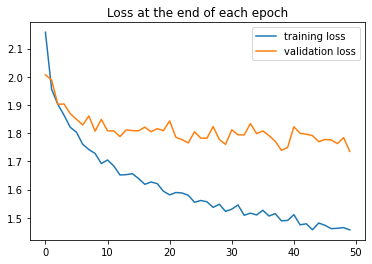

In [12]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

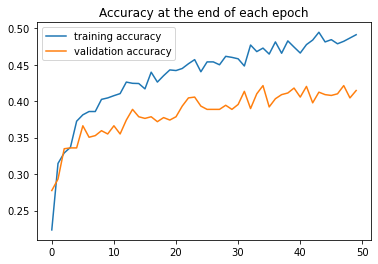

In [13]:
# plt.plot([t/100 for t in train_acc_list], label='training accuracy')
# plt.plot([t/100 for t in test_acc_list], label='validation accuracy')
plt.plot(train_acc_list, label='training accuracy')
plt.plot(test_acc_list, label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

# print(train_acc_list)
# print(test_acc_list)

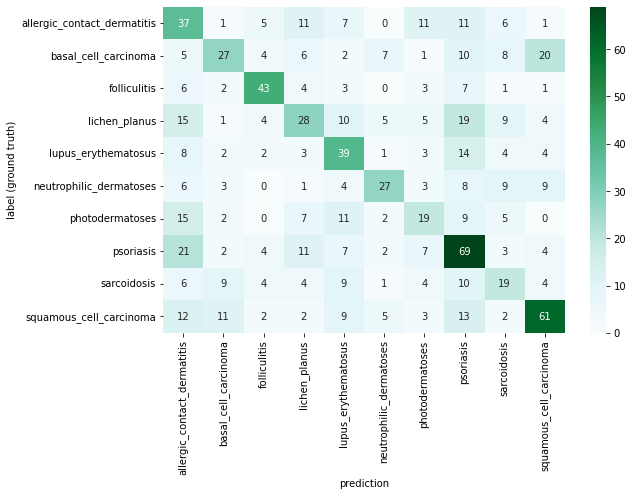

In [14]:
# Create a loader for the entire the test set
test_load_all = DataLoader(data['valid'], batch_size=10000, shuffle=False)
class_names = list(idx_to_class.values()) #classes are stored in a dictionary
# print(class_names)

resnet18.eval() #eval mode

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        
        X_test = X_test.to(device)
        y_test = y_test.to(device) 
        
        y_val = resnet18(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

# arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
y_test = y_test.cpu().numpy()
predicted = predicted.cpu().numpy()
# print(y_test)
# print(predicted)
arr = confusion_matrix(y_test.reshape(-1), predicted.reshape(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

In [15]:
#make sure model is in eval mode 
resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
#for inference...
from torchvision import transforms

transform = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
 ])

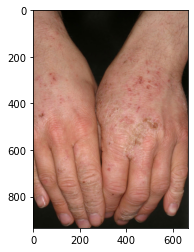

In [17]:
img = Image.open("2731.jpg")
plt.imshow(img)

In [18]:
img_t = transform(img)
batch_t = torch.unsqueeze(img_t, 0)

In [19]:
def inference(model, test_image_name):

    transform = image_transforms['valid']

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)

        topk, topclass = ps.topk(10, dim=1)
        cls = idx_to_class[topclass.cpu().numpy()[0][0]]
        score = topk.cpu().numpy()[0][0]

        for i in range(10):
            print("Prediction", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i]*100)

Prediction 1 : allergic_contact_dermatitis , Score:  61.70068979263306
Prediction 2 : psoriasis , Score:  16.04427397251129
Prediction 3 : lupus_erythematosus , Score:  11.157630383968353
Prediction 4 : photodermatoses , Score:  5.598330125212669
Prediction 5 : squamous_cell_carcinoma , Score:  1.518640574067831
Prediction 6 : sarcoidosis , Score:  1.5036795288324356
Prediction 7 : lichen_planus , Score:  1.4383185654878616
Prediction 8 : basal_cell_carcinoma , Score:  0.4582310561090708
Prediction 9 : neutrophilic_dermatoses , Score:  0.4287374671548605
Prediction 10 : folliculitis , Score:  0.15145851066336036


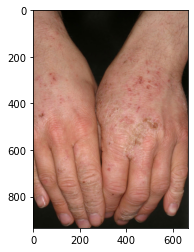

In [20]:
# inference test
model = torch.load("resnet_18_derm_model_test_v2.pt")
inference(model, "2731.jpg")